In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
os.environ['MKL_DEBUG_CPU_TYPE'] = '5' # 强制 MKL 使用兼容模式
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)
from src.data_loader import GasSensorLoader
from src.models import GasSensorMLP
# 1. 初始化加载器
loader = GasSensorLoader(data_dir='../Dataset') # 确保路径正确

# 2. 加载 Batch 1 (Week 1 定义的训练基准)
X_raw, y_raw = loader.load_batch(1)

# 3. 按协议 Reshape (N, 128) -> (N, 16, 8)
X_reshaped = X_raw.reshape(-1, 16, 8)
print(f"Loaded Shape: {X_raw.shape} -> Reshaped: {X_reshaped.shape}")

Loaded Shape: (445, 128) -> Reshaped: (445, 16, 8)


In [3]:
import numpy as np
#增强逻辑
def augment_gas_data(x, mode='jitter', sigma=0.05, scale_range=(0.9, 1.1)):
    """
    输入 x shape: (16, 8)
    """
    x_aug = x.copy()
    
    if mode == 'jitter':
        # 模拟电路噪声：添加微小高斯噪声
        noise = np.random.normal(0, sigma, x.shape)
        x_aug = x + noise
        
    elif mode == 'scaling':
        # 模拟传感器漂移：对每个通道 (C) 进行独立缩放
        # 每个通道 16 都有自己的缩放因子
        factors = np.random.uniform(scale_range[0], scale_range[1], (16, 1))
        x_aug = x * factors
        
    elif mode == 'permutation':
        # 模拟时序扰动：在 T 轴（8个特征）进行局部切片交换
        # 原则：不改变 C 轴顺序以维持传感器拓扑
        split = 4
        x_aug = np.concatenate([x[:, split:], x[:, :split]], axis=1)
        
    return x_aug

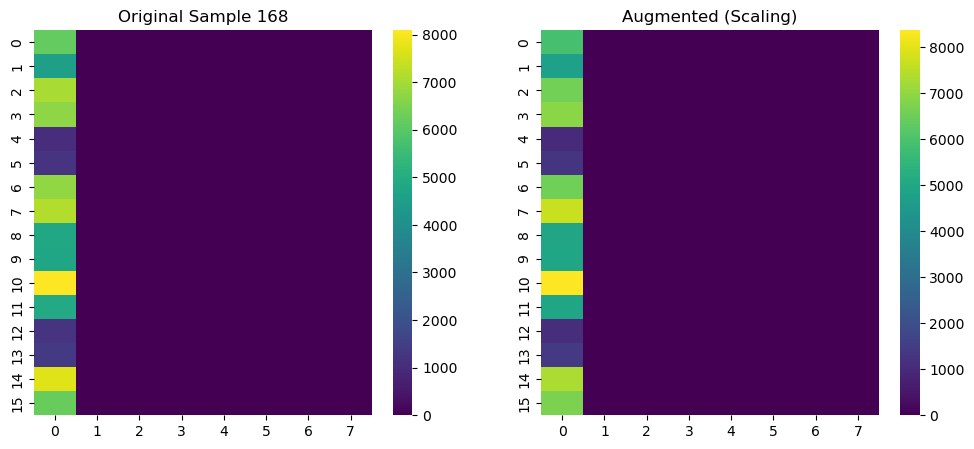

In [5]:
def plot_heatmap_comparison(X, idx, mode='scaling'):
    orig = X[idx]
    aug = augment_gas_data(orig, mode=mode)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    sns.heatmap(orig, ax=ax1, cmap='viridis')
    ax1.set_title(f"Original Sample {idx}")
    
    sns.heatmap(aug, ax=ax2, cmap='viridis')
    ax2.set_title(f"Augmented ({mode.capitalize()})")
    plt.show()

# 尝试可视化
plot_heatmap_comparison(X_reshaped, idx=np.random.randint(0, len(X_reshaped)), mode='scaling')


只有第 0 列（最左侧）有明显的颜色亮度（数值高达 25000+），而其它列几乎是深紫色。

物理含义：这说明在该样本中，稳态响应（Steady-state response） 是能量最高、最具辨识度的特征，而瞬态或其它特征值相对极小。这是典型的化学传感器响应模式。
需要对这 8 个特征进行 Standardization (Z-score) 或者 Log Transformation。否则，神经网络的权重会几乎全部被第 0 列（稳态特征）“吸走”，导致模型忽略掉描述气体动态特性的瞬态信息。   
官方提取了 8 个特征：第 1 个特征 ($f_1$)：这是最大电阻变化值 (Maximum Resistance Change)，即传感器在接触气体达到平衡后的稳态响应（Steady-state Response）。第 2-8 个特征 ($f_2$ 至 $f_8$)：这些是瞬态特征 (Transient Features)，描述了响应曲线的上升沿和下降沿（例如不同时间点的指数加权移动平均值）。

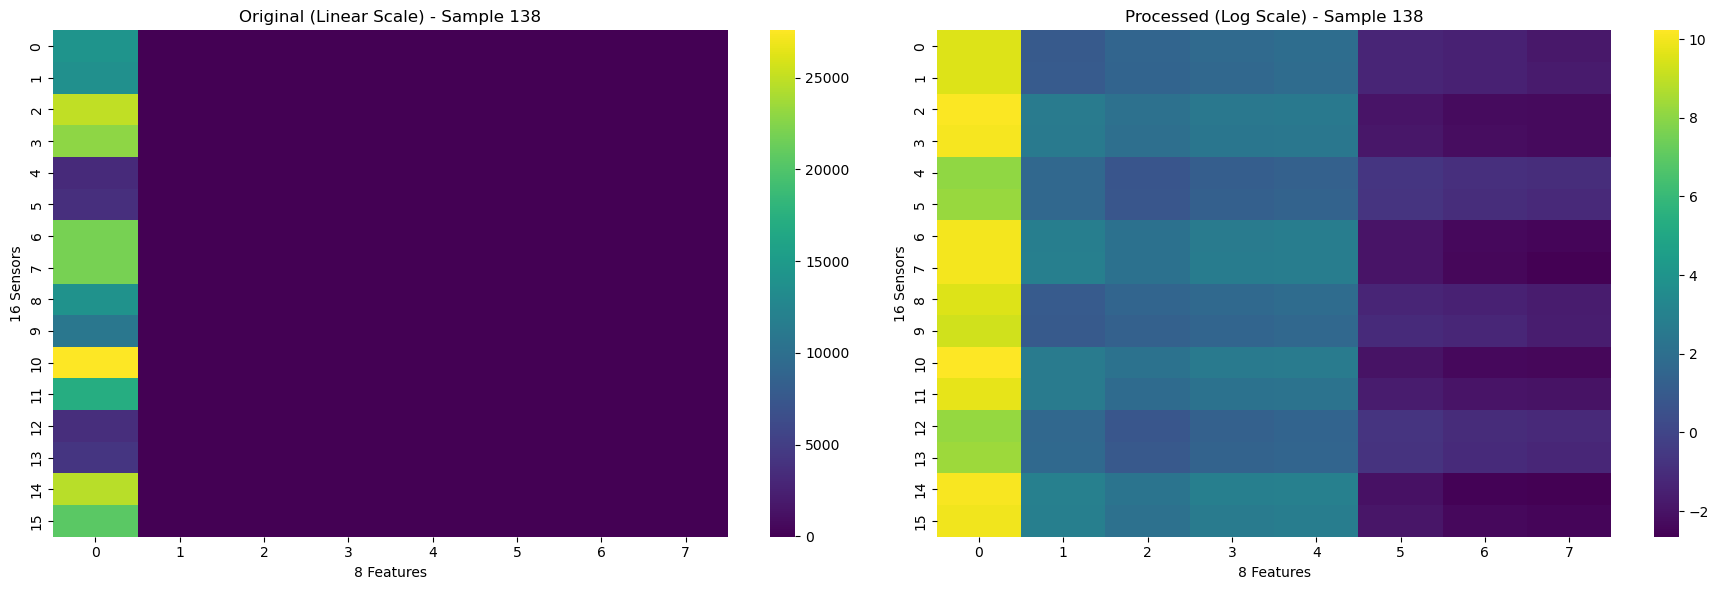

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 对数转换 (为了处理可能的负值或零，通常使用 log(1 + x))
# 注意：如果数据中有较大的负数，可以考虑先平移再取对数，或者直接使用标准化
X_log = np.log1p(np.abs(X_reshaped)) * np.sign(X_reshaped)

# 2. 选一个样本对比“转换前”与“转换后”
idx = 138 # 使用你刚才看到的那个样本
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# 原始数据热图
sns.heatmap(X_reshaped[idx], ax=ax1, cmap='viridis')
ax1.set_title(f"Original (Linear Scale) - Sample {idx}")
ax1.set_xlabel("8 Features")
ax1.set_ylabel("16 Sensors")

# 对数转换后的热图
sns.heatmap(X_log[idx], ax=ax2, cmap='viridis')
ax2.set_title(f"Processed (Log Scale) - Sample {idx}")
ax2.set_xlabel("8 Features")
ax2.set_ylabel("16 Sensors")

plt.tight_layout()
plt.show()

# test jitter

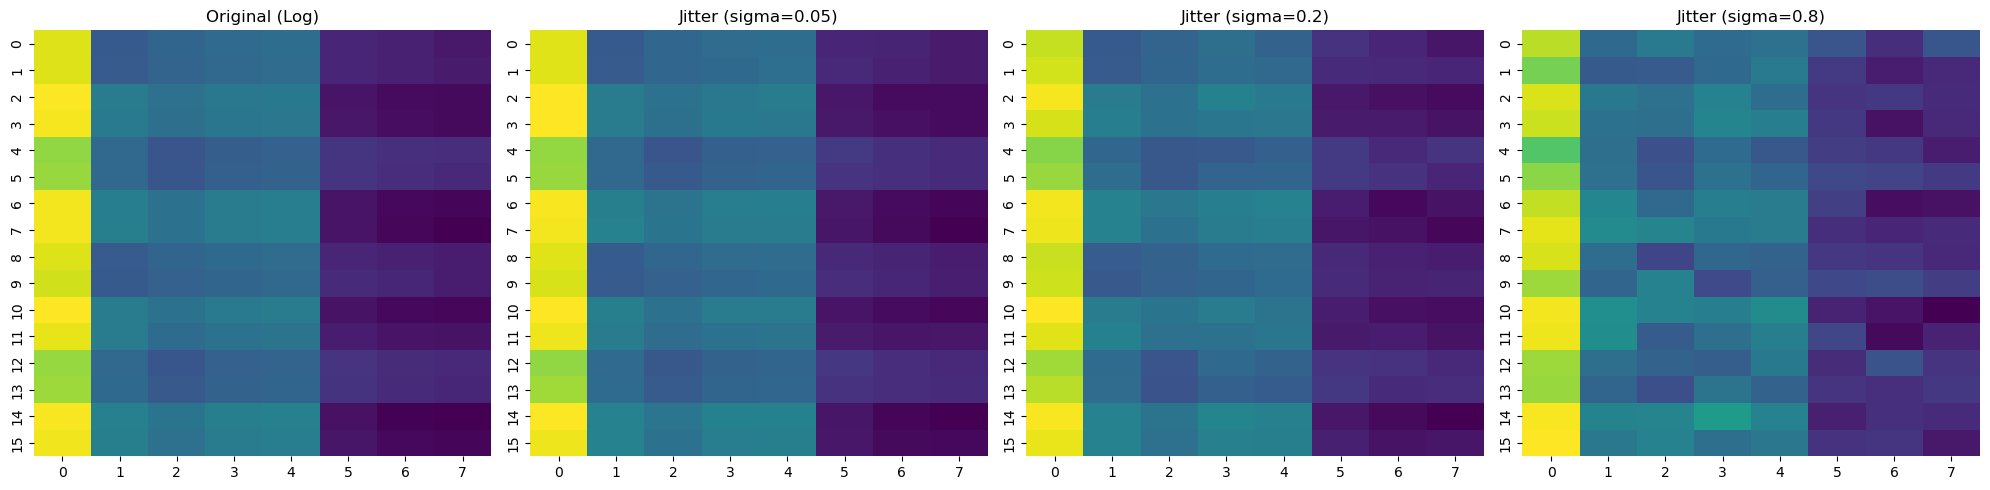

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 选择一个 Log 转换后的样本
sample = X_log[138]

# 模拟不同强度的 Jitter
# 0.05: 正常电路底噪 | 0.2: 强干扰环境 | 0.8: 传感器可能已损坏或电磁屏蔽失效
sigmas = [0.05, 0.2, 0.8]
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

# 原始图像
sns.heatmap(sample, ax=axes[0], cmap='viridis', cbar=False)
axes[0].set_title("Original (Log)")

for i, s in enumerate(sigmas):
    aug_sample = augment_gas_data(sample, mode='jitter', sigma=s)
    sns.heatmap(aug_sample, ax=axes[i+1], cmap='viridis', cbar=False)
    axes[i+1].set_title(f"Jitter (sigma={s})")

plt.tight_layout()
plt.show()

# test scaling

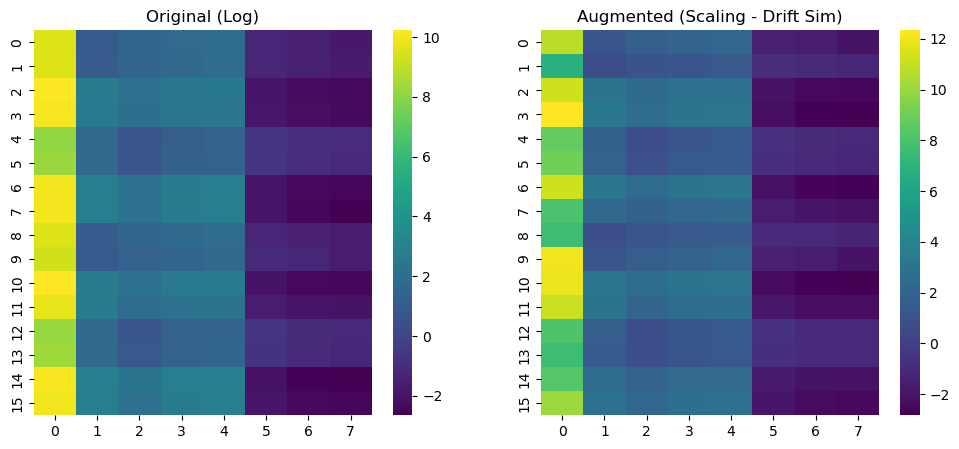

In [8]:
# 模拟 Scaling: 给 16 个传感器分别施加不均匀的缩放因子
def apply_scaling(x, sigma=0.2):
    # 为 16 个通道独立生成 0.8 到 1.2 之间的因子 (±20% 漂移)
    factors = np.random.uniform(1-sigma, 1+sigma, (16, 1))
    return x * factors

scaled_sample = apply_scaling(X_log[138], sigma=0.3) # 模拟较大的 30% 漂移

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(X_log[138], ax=ax1, cmap='viridis', cbar=True)
ax1.set_title("Original (Log)")

sns.heatmap(scaled_sample, ax=ax2, cmap='viridis', cbar=True)
ax2.set_title("Augmented (Scaling - Drift Sim)")
plt.show()

# permutation

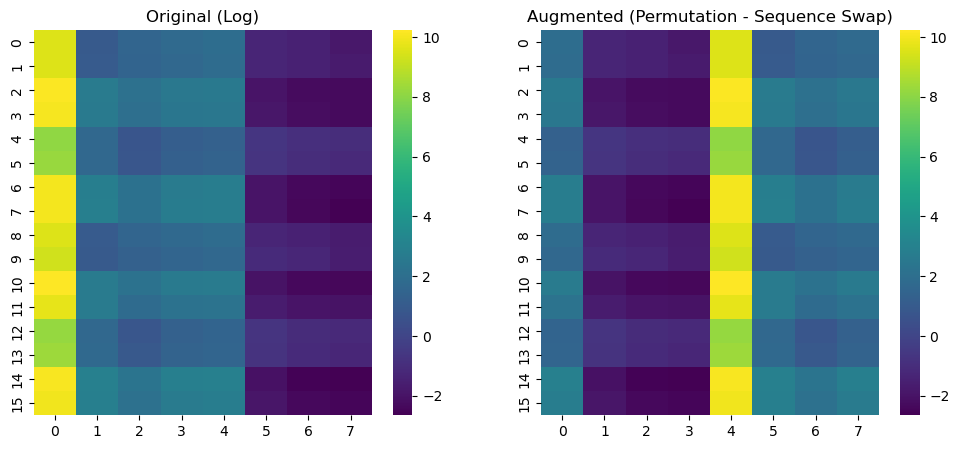

In [12]:
# 模拟 Permutation: 在 T 轴（8个特征）进行中点交换
def apply_permutation(x):
    res = x.copy()
    # 将 8 个特征分为 [0,1,2,3] 和 [4,5,6,7] 两部分并交换
    res[:, :4], res[:, 4:] = x[:, 4:], x[:, :4]
    return res

permuted_sample = apply_permutation(X_log[138])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(X_log[138], ax=ax1, cmap='viridis')
ax1.set_title("Original (Log)")

sns.heatmap(permuted_sample, ax=ax2, cmap='viridis')
ax2.set_title("Augmented (Permutation - Sequence Swap)")
plt.show()